In [1]:
# imports
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

np.random.seed(7)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
import os
os.getcwd()
os.chdir("C:\\Users\\Lenovo\\Documents\\Masters_thesis")
%pwd

'C:\\Users\\Lenovo\\Documents\\Masters_thesis'

In [3]:
FILE_DIR = "artifacts"
FILE_PATH = "nsp3_mutation_rate.csv"

In [4]:
data = pd.read_csv(os.path.join(FILE_DIR, FILE_PATH))
data.tail()

,AC,AT,AG,CA,CT,CG,TA,TC,TG,GA,GC,GT
13353,0.0,0.000000,0.000000,0.000001,0.000006,0.0,0.0,0.000001,0.0,0.000000,0.0,0.000000
13354,0.0,0.000000,0.000000,0.000001,0.000006,0.0,0.0,0.000001,0.0,0.000000,0.0,0.000000
13355,0.0,0.000000,0.000000,0.000000,0.000004,0.0,0.0,0.000003,0.0,0.000000,0.0,0.000001
13356,0.0,0.000000,0.000000,0.000003,0.000004,0.0,0.0,0.000001,0.0,0.000000,0.0,0.000000
13357,0.0,0.000001,0.000001,0.000001,0.000006,0.0,0.0,0.000001,0.0,0.000001,0.0,0.000000


In [5]:
converted_rates = data * 1e6

# Create a new DataFrame with the results
converted_df = pd.concat([converted_rates.index.to_frame(index=False), converted_rates], axis=1)

# Display the new DataFrame
del converted_df[0]
converted_df.tail()

,AC,AT,AG,CA,CT,CG,TA,TC,TG,GA,GC,GT
13353,0.0,0.000000,0.000000,1.282974,6.414868,0.0,0.0,1.282974,0.0,0.000000,0.0,0.000000
13354,0.0,0.000000,0.000000,1.282974,6.414868,0.0,0.0,1.282974,0.0,0.000000,0.0,0.000000
13355,0.0,0.000000,0.000000,0.000000,3.848921,0.0,0.0,2.565947,0.0,0.000000,0.0,1.282974
13356,0.0,0.000000,0.000000,2.565947,3.848921,0.0,0.0,1.282974,0.0,0.000000,0.0,0.000000
13357,0.0,1.282974,1.282974,1.282974,6.414868,0.0,0.0,1.282974,0.0,1.282974,0.0,0.000000


In [6]:
data = converted_df.round(5)
data.head(10)

,AC,AT,AG,CA,CT,CG,TA,TC,TG,GA,GC,GT
0,0.0,0.0,0.0,0.0,1.28297,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
1,0.0,0.0,0.0,0.0,1.28297,0.0,0.0,0.0,0.0,1.28297,0.0,0.0
2,0.0,0.0,0.0,0.0,1.28297,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
3,0.0,0.0,0.0,0.0,1.28297,0.0,0.0,0.0,0.0,1.28297,0.0,0.0
4,0.0,0.0,0.0,0.0,1.28297,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
5,0.0,0.0,0.0,0.0,1.28297,0.0,0.0,0.0,0.0,1.28297,0.0,0.0
6,0.0,0.0,0.0,0.0,1.28297,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
7,0.0,0.0,0.0,0.0,1.28297,0.0,0.0,0.0,0.0,1.28297,0.0,0.0
8,0.0,0.0,0.0,0.0,1.28297,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
9,0.0,0.0,0.0,0.0,1.28297,0.0,0.0,0.0,0.0,1.28297,0.0,0.0


In [7]:
data.to_csv(os.path.join("artifacts", "nsp3_mutation_rate_rounded6.csv"), index=False)

In [16]:
dataset = data.values
dataset = dataset.astype('float32')

print('Dataset Shape: ', np.shape(dataset))

Dataset Shape:  (13358, 12)


In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)


train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

10686 2672


In [18]:
def create_dataset(dataset, look_back, btch): 
    dataX, dataY = [], []
    z=0
    inc=1
    for i in range(0,len(dataset)-look_back,inc):
        a = dataset[i:(i+look_back)]
        
        dataX.append(np.reshape(a,(btch,12)))
        dataY.append(dataset[i+look_back])
#         print(a,dataY)
        z+=1
    return np.array(dataX), np.array(dataY)
 
btch=12    
look_back = 12
trainX, trainY = create_dataset(train, look_back, btch)
testX, testY = create_dataset(test, look_back, btch)

trainX = np.reshape(trainX, (trainX.shape[0], btch,12))
testX = np.reshape(testX, (testX.shape[0], btch, 12))
print(len(trainX), len(testX))

10674 2660


# Model 1: MinMax Scaler and LSTM Model

In [21]:
model = tf.keras.Sequential()
model.add(layers.LSTM(500,activation='relu', input_shape=(btch, 12))) 

model.add(layers.Dense(250))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(50))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12)) #softmax
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001))
history=model.fit(trainX, trainY, validation_split=0.30,epochs=400, batch_size=128, verbose=2)

# Find the minimum validation loss and its respective training loss and epoch
min_val_loss = min(history.history['val_loss'])
min_val_loss_epoch = history.history['val_loss'].index(min_val_loss)
train_loss_at_min_val_loss = history.history['loss'][min_val_loss_epoch]

# Print the results
print(f"Minimum Validation Loss: {min_val_loss} at Epoch {min_val_loss_epoch}")
print(f"Training Loss at Minimum Validation Loss: {train_loss_at_min_val_loss}")

Epoch 1/400
59/59 - 12s - loss: 0.0240 - val_loss: 0.0334 - 12s/epoch - 198ms/step
Epoch 2/400
59/59 - 11s - loss: 0.0222 - val_loss: 0.0298 - 11s/epoch - 181ms/step
Epoch 3/400
59/59 - 10s - loss: 0.0203 - val_loss: 0.0257 - 10s/epoch - 177ms/step
Epoch 4/400
59/59 - 10s - loss: 0.0185 - val_loss: 0.0214 - 10s/epoch - 172ms/step
Epoch 5/400
59/59 - 10s - loss: 0.0174 - val_loss: 0.0182 - 10s/epoch - 169ms/step
Epoch 6/400
59/59 - 12s - loss: 0.0168 - val_loss: 0.0168 - 12s/epoch - 211ms/step
Epoch 7/400
59/59 - 16s - loss: 0.0165 - val_loss: 0.0163 - 16s/epoch - 278ms/step
Epoch 8/400
59/59 - 17s - loss: 0.0161 - val_loss: 0.0156 - 17s/epoch - 294ms/step
Epoch 9/400
59/59 - 18s - loss: 0.0159 - val_loss: 0.0153 - 18s/epoch - 298ms/step
Epoch 10/400
59/59 - 17s - loss: 0.0158 - val_loss: 0.0149 - 17s/epoch - 289ms/step
Epoch 11/400
59/59 - 18s - loss: 0.0156 - val_loss: 0.0147 - 18s/epoch - 312ms/step
Epoch 12/400
59/59 - 18s - loss: 0.0153 - val_loss: 0.0143 - 18s/epoch - 305ms/step
E

Epoch 99/400
59/59 - 17s - loss: 0.0116 - val_loss: 0.0098 - 17s/epoch - 284ms/step
Epoch 100/400
59/59 - 16s - loss: 0.0116 - val_loss: 0.0097 - 16s/epoch - 276ms/step
Epoch 101/400
59/59 - 16s - loss: 0.0115 - val_loss: 0.0097 - 16s/epoch - 273ms/step
Epoch 102/400
59/59 - 16s - loss: 0.0115 - val_loss: 0.0096 - 16s/epoch - 270ms/step
Epoch 103/400
59/59 - 16s - loss: 0.0115 - val_loss: 0.0096 - 16s/epoch - 268ms/step
Epoch 104/400
59/59 - 16s - loss: 0.0114 - val_loss: 0.0096 - 16s/epoch - 274ms/step
Epoch 105/400
59/59 - 16s - loss: 0.0115 - val_loss: 0.0096 - 16s/epoch - 276ms/step
Epoch 106/400
59/59 - 16s - loss: 0.0114 - val_loss: 0.0096 - 16s/epoch - 276ms/step
Epoch 107/400
59/59 - 16s - loss: 0.0115 - val_loss: 0.0095 - 16s/epoch - 273ms/step
Epoch 108/400
59/59 - 17s - loss: 0.0114 - val_loss: 0.0094 - 17s/epoch - 285ms/step
Epoch 109/400
59/59 - 17s - loss: 0.0114 - val_loss: 0.0093 - 17s/epoch - 291ms/step
Epoch 110/400
59/59 - 19s - loss: 0.0114 - val_loss: 0.0094 - 19s/

Epoch 196/400
59/59 - 16s - loss: 0.0103 - val_loss: 0.0088 - 16s/epoch - 271ms/step
Epoch 197/400
59/59 - 16s - loss: 0.0103 - val_loss: 0.0088 - 16s/epoch - 273ms/step
Epoch 198/400
59/59 - 16s - loss: 0.0103 - val_loss: 0.0089 - 16s/epoch - 273ms/step
Epoch 199/400
59/59 - 16s - loss: 0.0103 - val_loss: 0.0088 - 16s/epoch - 273ms/step
Epoch 200/400
59/59 - 16s - loss: 0.0103 - val_loss: 0.0090 - 16s/epoch - 276ms/step
Epoch 201/400
59/59 - 16s - loss: 0.0102 - val_loss: 0.0088 - 16s/epoch - 279ms/step
Epoch 202/400
59/59 - 16s - loss: 0.0103 - val_loss: 0.0088 - 16s/epoch - 267ms/step
Epoch 203/400
59/59 - 16s - loss: 0.0102 - val_loss: 0.0088 - 16s/epoch - 270ms/step
Epoch 204/400
59/59 - 16s - loss: 0.0103 - val_loss: 0.0088 - 16s/epoch - 275ms/step
Epoch 205/400
59/59 - 18s - loss: 0.0102 - val_loss: 0.0089 - 18s/epoch - 312ms/step
Epoch 206/400
59/59 - 16s - loss: 0.0102 - val_loss: 0.0088 - 16s/epoch - 273ms/step
Epoch 207/400
59/59 - 16s - loss: 0.0102 - val_loss: 0.0088 - 16s

Epoch 293/400
59/59 - 18s - loss: 0.0098 - val_loss: 0.0086 - 18s/epoch - 309ms/step
Epoch 294/400
59/59 - 18s - loss: 0.0098 - val_loss: 0.0087 - 18s/epoch - 306ms/step
Epoch 295/400
59/59 - 18s - loss: 0.0098 - val_loss: 0.0086 - 18s/epoch - 297ms/step
Epoch 296/400
59/59 - 18s - loss: 0.0098 - val_loss: 0.0086 - 18s/epoch - 300ms/step
Epoch 297/400
59/59 - 18s - loss: 0.0098 - val_loss: 0.0086 - 18s/epoch - 300ms/step
Epoch 298/400
59/59 - 17s - loss: 0.0097 - val_loss: 0.0085 - 17s/epoch - 295ms/step
Epoch 299/400
59/59 - 17s - loss: 0.0098 - val_loss: 0.0086 - 17s/epoch - 292ms/step
Epoch 300/400
59/59 - 18s - loss: 0.0098 - val_loss: 0.0085 - 18s/epoch - 301ms/step
Epoch 301/400
59/59 - 18s - loss: 0.0098 - val_loss: 0.0085 - 18s/epoch - 299ms/step
Epoch 302/400
59/59 - 18s - loss: 0.0098 - val_loss: 0.0086 - 18s/epoch - 298ms/step
Epoch 303/400
59/59 - 18s - loss: 0.0098 - val_loss: 0.0086 - 18s/epoch - 299ms/step
Epoch 304/400
59/59 - 18s - loss: 0.0098 - val_loss: 0.0085 - 18s

Epoch 390/400
59/59 - 10s - loss: 0.0096 - val_loss: 0.0085 - 10s/epoch - 172ms/step
Epoch 391/400
59/59 - 10s - loss: 0.0095 - val_loss: 0.0084 - 10s/epoch - 172ms/step
Epoch 392/400
59/59 - 10s - loss: 0.0096 - val_loss: 0.0085 - 10s/epoch - 171ms/step
Epoch 393/400
59/59 - 10s - loss: 0.0096 - val_loss: 0.0084 - 10s/epoch - 171ms/step
Epoch 394/400
59/59 - 10s - loss: 0.0096 - val_loss: 0.0085 - 10s/epoch - 171ms/step
Epoch 395/400
59/59 - 10s - loss: 0.0096 - val_loss: 0.0085 - 10s/epoch - 171ms/step
Epoch 396/400
59/59 - 10s - loss: 0.0095 - val_loss: 0.0085 - 10s/epoch - 174ms/step
Epoch 397/400
59/59 - 10s - loss: 0.0095 - val_loss: 0.0085 - 10s/epoch - 169ms/step
Epoch 398/400
59/59 - 10s - loss: 0.0096 - val_loss: 0.0085 - 10s/epoch - 173ms/step
Epoch 399/400
59/59 - 10s - loss: 0.0095 - val_loss: 0.0085 - 10s/epoch - 171ms/step
Epoch 400/400
59/59 - 10s - loss: 0.0095 - val_loss: 0.0085 - 10s/epoch - 170ms/step
Minimum Validation Loss: 0.008350366726517677 at Epoch 388
Traini

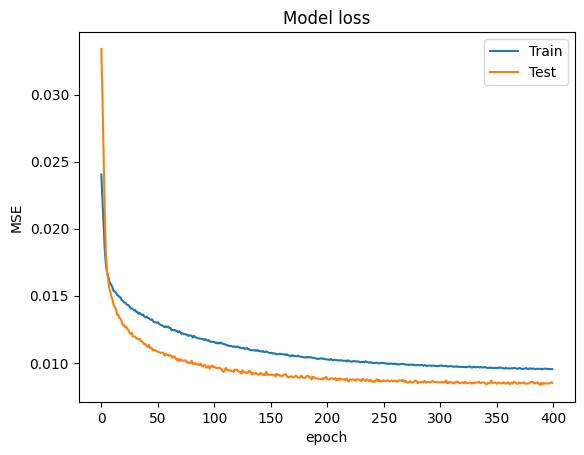

In [22]:
plt.plot(history.history['loss'])
plt.plot(np.array(history.history['val_loss']))
plt.title('Model loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [23]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


# invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

#calculating error

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

84/84 [==============================] - 3s 33ms/step
Train Score: 0.61 RMSE
Test Score: 0.65 RMSE


In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 500)               1026000   
                                                                 
 dense_3 (Dense)             (None, 250)               125250    
                                                                 
 activation_2 (Activation)   (None, 250)               0         
                                                                 
 dropout_2 (Dropout)         (None, 250)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                12550     
                                                                 
 activation_3 (Activation)   (None, 50)                0         
                                                                 
 dropout_3 (Dropout)         (None, 50)               